In [1]:
import os
from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.parser import TSVDocPreprocessor
    
doc_preprocessor = TSVDocPreprocessor('/users/anirudhmuthukumar/downloads/snorkel-master/myscripts/data/Format-4 RTT.tsv')

In [3]:
from snorkel.parser.spacy_parser import Spacy
from snorkel.parser import CorpusParser

corpus_parser = CorpusParser(parser=Spacy())
%time c = corpus_parser.apply(doc_preprocessor)

Clearing existing...
Running UDF...
CPU times: user 54.9 s, sys: 995 ms, total: 55.9 s
Wall time: 56.3 s


In [4]:
from snorkel.models import Document, Sentence

print("Documents:", session.query(Document).count())
print("Sentences:", session.query(Sentence).count())

('Documents:', 26323)
('Sentences:', 26323)


## Splitting the dataset into three sets 

In [5]:
docs = session.query(Document).order_by(Document.name).all()

train_sents = set()
dev_sents   = set()
test_sents  = set()

for i, doc in enumerate(docs):
    for s in doc.sentences:
            if i % 200 == 8:
                dev_sents.add(s)
            elif i % 26 == 9:
                test_sents.add(s)
            else:
                train_sents.add(s)
                
len(dev_sents), len(train_sents), len(test_sents)

(2632, 21059, 2632)

Sample format of the sentences 

In [6]:
session.query(Sentence).all()

[Sentence(Document 1,0,273.0 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 ),
 Sentence(Document 2,0,263.0 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 ),
 Sentence(Document 3,0,262.0 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
 ),
 Sentence(Document 4,0,281.0 AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### Defining candidate subclass 
`Candidates` are basically potential mentions found in text in which we are interested in for training the model.

In [7]:
from snorkel.models import candidate_subclass

Person = candidate_subclass('Person', ['person'])
Number = candidate_subclass('rttvalue', ['number1', 'number2'])

In [8]:
from snorkel.candidates import Ngrams, CandidateExtractor
from snorkel.matchers import RegexMatchEach

ngrams         = Ngrams(n_max=1)
string_matcher = RegexMatchEach(rgx='^[A]+$')
number_matcher = RegexMatchEach(rgx='^[0-9]+.[0-9]+$')
cand_extractor = CandidateExtractor(Number, [ngrams, ngrams], [number_matcher, string_matcher])

### Applying `CandidateExtractor` to three sets of data

In [9]:
for i, sents in enumerate([train_sents, dev_sents, test_sents]):
    %time cand_extractor.apply(sents, split=i)
    print("Number of candidates:", session.query(Number).filter(Number.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 41.4 s, sys: 569 ms, total: 42 s
Wall time: 42.4 s
('Number of candidates:', 21059)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 5.91 s, sys: 191 ms, total: 6.1 s
Wall time: 6.24 s
('Number of candidates:', 2632)
Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 5.51 s, sys: 193 ms, total: 5.7 s
Wall time: 5.77 s
('Number of candidates:', 2632)


In [10]:
train_cands = session.query(Number).filter(Number.split == 0).all()
dev_cands = session.query(Number).filter(Number.split == 1).all()
test_cands = session.query(Number).filter(Number.split == 2).all()

In [11]:
train_cands

[rttvalue(Span("269.0", sentence=46308, chars=[0,4], words=[0,0]), Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=46308, chars=[6,274], words=[1,1])),
 rttvalue(Span("263.0", sentence=45592, chars=[0,4], words=[0,0]), Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=45592, chars=[6,268], words=[1,1])),
 rttvalue(Span("275.0", sentence=44129, chars=[0,4], words=[0,0]), Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

## Defining labelling function 

In [36]:
def LF_Good_Measurement(c):
    val = c.number1.get_attrib_tokens()
    if float(val[0])<=300:
        return 1
    else:
        return 0

In [37]:
LFs = [ LF_Good_Measurement] 

In [38]:
labeled = []
for c in train_cands:
    if LF_Good_Measurement(c) != 0:
        labeled.append(c)
print("Total Candidates: ", len(train_cands))
print("Number labeled:", len(labeled))

('Total Candidates: ', 21059)
('Number labeled:', 19957)


In [103]:
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(dev_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzExNjBdXSwgW1syNjAwXV0sIFtbODc2XV0sIFtbMTc4MF1dLCBbWzEwNzldXSwgW1s2MTNdXSwgW1syMzhdXSwgW1sxMTc2XV0sIFtbNzcwXV3igKY=


### Loading the annotated dev set 

In [136]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(session, annotator_name=os.environ['USER'], split=1)
L_gold_dev

<2632x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1506 stored elements in Compressed Sparse Row format>

In [121]:
from snorkel.annotations import LabelAnnotator
import numpy as np

labeler = LabelAnnotator(lfs=LFs)

np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 18s, sys: 1.72 s, total: 1min 19s
Wall time: 1min 23s


<21059x1 sparse matrix of type '<type 'numpy.int64'>'
	with 19957 stored elements in Compressed Sparse Row format>

In [122]:
L_train.lf_stats(session)

j  Coverage  Overlaps  Conflicts
LF_Good_Measurement  0  0.947671       0.0        0.0

In [123]:
L_train.get_candidate(session, 0)

rttvalue(Span("269.0", sentence=46308, chars=[0,4], words=[0,0]), Span("AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA", sentence=46308, chars=[6,274], words=[1,1]))

In [124]:
np.random.seed(1701)

%time L_dev = labeler.apply_existing(split=1, lfs=LFs, parallelism=1)
print L_dev.shape
L_dev

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 10.8 s, sys: 234 ms, total: 11 s
Wall time: 11.5 s
(2632, 1)


<2632x1 sparse matrix of type '<type 'numpy.int64'>'
	with 2492 stored elements in Compressed Sparse Row format>

In [125]:
L_dev.lf_stats(session, labels=L_gold_dev.toarray().ravel())

j  Coverage  Overlaps  Conflicts    TP  FP  FN  TN  \
LF_Good_Measurement  0  0.946809       0.0        0.0  1420   0   0   0   

                     Empirical Acc.  
LF_Good_Measurement             1.0

## Gen model 

In [126]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [127]:
gen_model.weights.lf_accuracy

array([1.51547632])

In [128]:
train_marginals = gen_model.marginals(L_train)
train_marginals

array([0.95395304, 0.95395304, 0.95395304, ..., 0.95395304, 0.95395304,
       0.95395304])

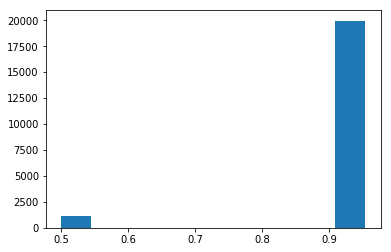

In [129]:
import matplotlib.pyplot as plt
plt.hist(train_marginals)
plt.show()

In [130]:
gen_model.learned_lf_stats()

Accuracy  Coverage  Precision    Recall
0  0.952558    0.8326   0.953596  0.795178

## Evaluating our model for dev set 

In [131]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [132]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.999
Neg. class accuracy: 0.115
Precision            0.57
Recall               0.999
F1                   0.726
----------------------------------------
TP: 1420 | FP: 1072 | TN: 139 | FN: 1



#### Accuracy = (1420+139) / ( 1420+139+1072+1)
         = <b>59.23%<b>

## Investigating false positives 

In [80]:
SentenceNgramViewer(fp, session)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzI5N10sIFsxOTQ3XSwgWzYwOF1dLCBbWzEzODZdLCBbMTIzM10sIFsxNjYxXV0sIFtbNDM5XSwgWzEyMDJdLCBbNzY3XV0sIFtbMjE0NV0sIFvigKY=


## Naive Bayes Classifier 

In [51]:
from snorkelTG.learning import NaiveBayes

gen_model = NaiveBayes()
gen_model.train(L_train, n_iter=1000, rate=1e-5)

/Users/anirudhmuthukumar/Downloads/snorkel-master/snorkelTG/learning_utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/anaco

Training marginals (!= 0.5):	21059
Features:			1
Begin training for rate=1e-05, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.000000
SGD converged for mu=1e-06 after 10 steps


In [52]:
train_marginals = gen_model.marginals(L_train)

## Discriminative model 

In [81]:
from snorkel.viewer import SentenceNgramViewer

SentenceNgramViewer(test_cands, session, n_per_page=1)

<IPython.core.display.Javascript object>

U2VudGVuY2VOZ3JhbVZpZXdlcihjaWRzPVtbWzE5M11dLCBbWzExOF1dLCBbWzE5NV1dLCBbWzEzMDldXSwgW1sxMDU4XV0sIFtbMjEzM11dLCBbWzM5OV1dLCBbWzE4NzRdXSwgW1sxMTUxXV3igKY=


In [99]:
L_gold_test = load_gold_labels(session, annotator_name=os.environ['USER'], split=2)
L_gold_test

<2632x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1007 stored elements in Compressed Sparse Row format>

In [133]:
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1,
    'batch_size': 128,
    'max_sentence_length': 100
}

lstm = reRNN(seed=1701, n_threads=1)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=L_gold_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=19957  #epochs=10  batch size=128
[reRNN] Epoch 0 (56.66s)	Average loss=0.220160	Dev F1=70.12
[reRNN] Epoch 1 (116.73s)	Average loss=0.186711	Dev F1=70.12
[reRNN] Epoch 2 (176.60s)	Average loss=0.186708	Dev F1=70.12
[reRNN] Epoch 3 (236.57s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Epoch 4 (296.43s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Epoch 5 (356.38s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Epoch 6 (416.15s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Epoch 7 (475.93s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Epoch 8 (535.84s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (616.11s)	Average loss=0.186707	Dev F1=70.12
[reRNN] Training done (619.67s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>


## Precision on test candidates  

In [134]:
p, r, f1 = lstm.score(test_cands, L_gold_test)
print("Prec: {0:.3f}, Recall: {1:.3f}, F1 Score: {2:.3f}".format(p, r, f1))

Prec: 0.364, Recall: 1.000, F1 Score: 0.534


In [135]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, L_gold_test)

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.364
Recall               1.0
F1                   0.534
----------------------------------------
TP: 959 | FP: 1673 | TN: 0 | FN: 0



In [137]:
L_gold_dev

<2632x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1506 stored elements in Compressed Sparse Row format>

In [138]:
L_gold_test

<2632x1 sparse matrix of type '<type 'numpy.int64'>'
	with 1007 stored elements in Compressed Sparse Row format>